# DistilBERT fine-tuning으로 감정 분석 모델 학습하기

이번 실습에서는 pre-trained된 DistilBERT를 불러와 이전 주차 실습에서 사용하던 감정 분석 문제에 적용합니다. 먼저 필요한 library들을 불러옵니다.

In [1]:
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses datasets hf_xet

그 후, 우리가 사용하는 DistilBERT pre-training 때 사용한 tokenizer를 불러옵니다.

In [2]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'distilbert-base-uncased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DistilBERT의 tokenizer를 불러왔으면 이제 `collate_fn`과 data loader를 정의합니다. 이 과정은 이전 실습과 동일하게 다음과 같이 구현할 수 있습니다.

In [3]:
# fancyzhx/ag_news 데이터셋의 5%만 로드 (학습 데이터와 테스트 데이터 각각)
train_ds = load_dataset("fancyzhx/ag_news", split="train[:5%]")
test_ds = load_dataset("fancyzhx/ag_news", split="test[:5%]")

# 데이터를 배치로 묶기 위한 함수 정의
def collate_fn(batch):
    max_len = 400  # 입력 문장의 최대 길이 설정
    texts, labels = [], []  # 입력 문장들과 라벨들을 저장할 리스트

    # 배치 내 각 샘플에 대해 text와 label 추출
    for row in batch:
        labels.append(row['label'])
        texts.append(row['text'])

    # tokenizer로 텍스트를 토큰화하고, 최대 길이로 패딩 및 자르기
    # tokenizer는 사전에 정의되어 있어야 함 (예: tokenizer = AutoTokenizer.from_pretrained(...))
    texts = torch.LongTensor(
        tokenizer(texts, padding=True, max_length=max_len).input_ids
    )

    # 라벨 리스트를 LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 모델 학습에 필요한 입력 (토큰화된 문장들)과 정답 라벨 반환
    return texts, labels

# 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [4]:
print(train_ds)

Dataset({
    features: ['text', 'label'],
    num_rows: 6000
})


In [5]:
n_class = len(set(train_ds['label']))
print(n_class)

4


이제 pre-trained DistilBERT를 불러옵니다. 이번에는 PyTorch hub에서 제공하는 DistilBERT를 불러봅시다.

In [6]:
#DistilBERT 모델을 PyTorch Hub에서 로드 후 model 출력
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')
model

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

출력 결과를 통해 우리는 DistilBERT의 architecture는 일반적인 Transformer와 동일한 것을 알 수 있습니다.
Embedding layer로 시작해서 여러 layer의 Attention, FFN를 거칩니다.

이제 DistilBERT를 거치고 난 `[CLS]` token의 representation을 가지고 text 분류를 하는 모델을 구현합시다.

In [7]:
from torch import nn

# 텍스트 분류 모델 정의 (DistilBERT + Linear layer)
class TextClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 불러옴 (pretrained transformer)
        self.encoder = torch.hub.load('huggingface/pytorch-transformers', 'model', 'distilbert-base-uncased')


        # [CLS] 토큰 분류기 정의
        self.classifier = nn.Linear(768, n_class)

    def forward(self, x):
        # encoder에 input_ids 전달
        x = self.encoder(x)['last_hidden_state']

        # print(f'x shape: {x.shape}') # torch.Size([64, 127, 768])
        # [CLS] 토큰 위치 벡터를 classification head에 전달
        x = self.classifier(x[:, 0])
        # print(f'x shape: {x.shape}') # torch.Size([64, 4])

        return x  # logit 출력

model = TextClassifier()

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


위와 같이 `TextClassifier`의 `encoder`를 불러온 DistilBERT, 그리고 `classifier`를 linear layer로 설정합니다.
그리고 `forward` 함수에서 순차적으로 사용하여 예측 결과를 반환합니다.

다음은 마지막 classifier layer를 제외한 나머지 부분을 freeze하는 코드를 구현합니다.

In [8]:
for param in model.encoder.parameters():
  param.requires_grad = False

위의 코드는 `encoder`에 해당하는 parameter들의 `requires_grad`를 `False`로 설정하는 모습입니다.
`requires_grad`를 `False`로 두는 경우, gradient 계산 및 업데이트가 이루어지지 않아 결과적으로 학습이 되지 않습니다.
즉, 마지막 `classifier`에 해당하는 linear layer만 학습이 이루어집니다.
이런 식으로 특정 부분들을 freeze하게 되면 효율적으로 학습을 할 수 있습니다.

마지막으로 이전과 같은 코드를 사용하여 학습 결과를 확인해봅시다.

In [9]:
def accuracy(model, dataloader):
    cnt = 0      # 전체 샘플 수
    acc = 0      # 정답 개수 누적

    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)  # 로짓(logit) 출력
        # print(f'before preds shape: {preds.shape}') # torch.Size([64, 4])

        # 시그모이드는 생략 가능 (BCEWithLogitsLoss를 썼다면 threshold만 적용)
        preds = torch.argmax(preds, dim=-1)
        # preds = (preds > 0).long()[..., 0]
        # print(f'after preds shape: {preds.shape}') # torch.Size([64])

        cnt += labels.shape[0]  # 총 샘플 수 누적
        acc += (labels == preds).sum().item()  # 예측이 맞은 수 누적

    return acc / cnt  # 정확도 반환

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch   0 | Train Loss: 99.87966120243073
=========> Train acc: 0.785 | Test acc: 0.816
Epoch   1 | Train Loss: 69.44543653726578
=========> Train acc: 0.825 | Test acc: 0.839
Epoch   2 | Train Loss: 59.578701585531235
=========> Train acc: 0.838 | Test acc: 0.837
Epoch   3 | Train Loss: 54.57761213183403
=========> Train acc: 0.836 | Test acc: 0.834
Epoch   4 | Train Loss: 51.92544296383858
=========> Train acc: 0.841 | Test acc: 0.832
Epoch   5 | Train Loss: 48.76595005393028
=========> Train acc: 0.840 | Test acc: 0.847
Epoch   6 | Train Loss: 47.886100590229034
=========> Train acc: 0.852 | Test acc: 0.855
Epoch   7 | Train Loss: 46.51770544052124
=========> Train acc: 0.841 | Test acc: 0.855
Epoch   8 | Train Loss: 45.62737995386124
=========> Train acc: 0.853 | Test acc: 0.847
Epoch   9 | Train Loss: 44.58152461051941
=========> Train acc: 0.854 | Test acc: 0.853


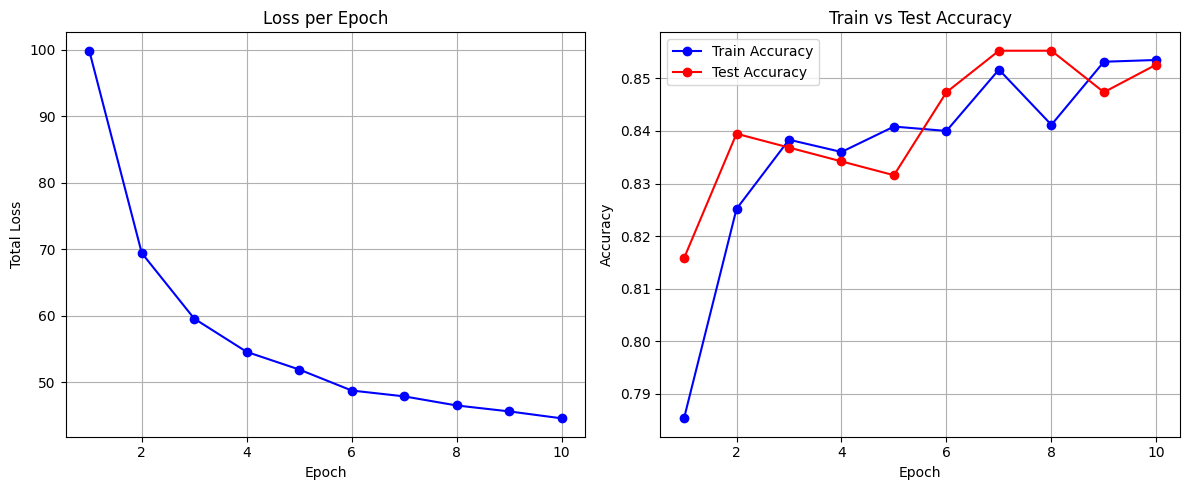

In [10]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

# 학습 설정
lr = 0.001
model = model.to('cuda')  # 모델을 GPU로 이동
loss_fn = nn.CrossEntropyLoss()  #  다중 분류용 손실 함수

optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 10

# 측정값 저장을 위한 리스트 생성
epoch_losses = []
train_accuracies = []
test_accuracies = []

# 학습 루프
for epoch in range(n_epochs):
    total_loss = 0.
    model.train()  # 학습 모드 설정

    for data in train_loader:
        model.zero_grad()  # 이전 gradient 초기화

        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda').long()  # GPU 이동 및 long 변환

        # print(f'inputs shape: {inputs.shape}, labels shape: {labels.shape}')
        # inputs shape: torch.Size([64, 174]), labels shape: torch.Size([64])
        # preds = model(inputs)[..., 0]  # 출력 차원 맞추기 (batch_size,)
        preds = model(inputs)
        # print(f'preds shape: {preds.shape}') # preds shape: torch.Size([64, 4])

        loss = loss_fn(preds, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 파라미터 업데이트

        total_loss += loss.item()  # loss 누적

    # 각 에폭의 손실값 저장
    epoch_losses.append(total_loss)

    print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

    # 평가 시 gradient 계산 비활성화
    with torch.no_grad():
        model.eval()  # 평가 모드로 전환 (계산 비활성화)
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)

        # 정확도 저장
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

# 학습 완료 후 그래프 그리기
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs+1), epoch_losses, 'o-', color='blue')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.grid(True)

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs+1), train_accuracies, 'o-', color='blue', label='Train Accuracy')
plt.plot(range(1, n_epochs+1), test_accuracies, 'o-', color='red', label='Test Accuracy')
plt.title('Train vs Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_results.png')  # 그래프 저장 (선택사항)
plt.show()